# Mathieu equation

eigenvalue problem on $\textbf{x}\in\Omega$

$$\nabla^2u + (\lambda - 2q\cos(\textbf{k}\cdot\textbf{x})) u = 0$$

$$\left[-\nabla^2 + 2q\cos(\textbf{k}\cdot\textbf{x})\right]u = \lambda u$$

In [1]:
import numpy as np
from cycler import cycler
from dolfinx.fem import FunctionSpace
from ufl import (Form, dx, inner, grad, cos, 
    TestFunction, TrialFunction, SpatialCoordinate,
)

from lucifex.mesh import interval_mesh
from lucifex.fem import LUCiFExConstant as Constant
from lucifex.solver import evp_solver, EigenvalueProblem, BoundaryConditions, OptionsSLEPc
from lucifex.viz import plot_line


def mathieu(
    fs: FunctionSpace,
    q: Constant,
    k: Constant,
) -> tuple[Form, Form]:
    v = TestFunction(fs)
    u = TrialFunction(fs)
    x = SpatialCoordinate(fs.mesh)
    lhs = inner(grad(v), grad(u)) * dx
    lhs += 2 * v * q * cos(inner(k, x)) * u * dx
    rhs = v * u * dx
    return lhs, rhs

### Example: $d=1$ interval

$$\Omega = [0, L_x]$$

$$\textbf{k}=2\,\textbf{e}_x$$

$$u(x=0, L_x)=0$$

$$q=0\implies\frac{\text{d}^2u}{\text{d}x^2} + \lambda u =0~,~u_n(x)=\sin(\sqrt{\lambda_n}x)~,~\lambda_n=\frac{n^2\pi^2}{L_x^2}$$

In [ ]:
def mathieu_1d_solver(
    Lx: float,
    Nx: int,
    bcs: BoundaryConditions, 
    q: float,
    k: float,
    nev: int,
) -> EigenvalueProblem:
    mesh = interval_mesh(Lx, Nx)
    q = Constant(mesh, q)
    k = Constant(mesh, (k, ))

    fs = FunctionSpace(mesh, ('P', 1))
    slepc = OptionsSLEPc(
        eps_tol=1e-10,
        eps_target=0.0,
        eps_nev=nev,
        eps_ncv=50,
        eps_max_it=1000,
        eps_which='smallest_real',
    )
    u_solver = evp_solver(mathieu, bcs, slepc)(fs, q, k)
    return u_solver


Lx = 1.0
Nx = 200
bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[0], 0.0),
        ('dirichlet', lambda x: x[0] - Lx, 0.0),
    )
nev = 3
k = 2.0

q_axis = np.linspace(0, 20, num=10)
solvers = [mathieu_1d_solver(Lx, Nx, bcs, q, k, nev) for q in q_axis]

In [13]:
[s.solve() for s in solvers]
eigenvalues = [s.eigenvalues for s in solvers]
eigenreals = [[np.real(l) for l in lmbdas] for lmbdas in eigenvalues]
eigenreals_q0 = [(n * np.pi/ Lx) ** 2 for n in range(nev)]

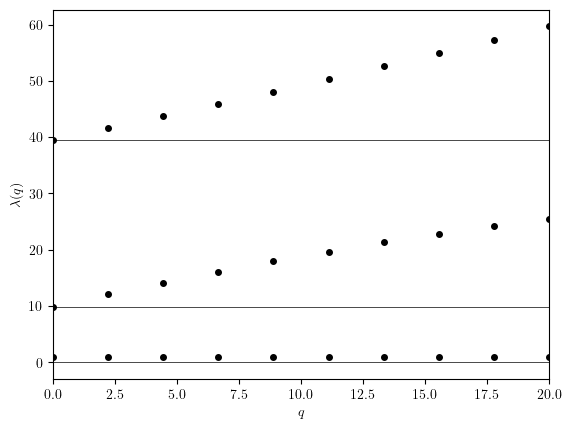

In [ ]:
lines = [
    (q_axis, [eigenreals[q_index][n] for q_index in range(len(q_axis))])
    for n in range(nev)
]
cyc = cycler(linestyle=['dotted'], marker=['o'], ms=[4], color=['black'])
fig, ax = plot_line(
    lines, 
    cyc=cyc,
    x_label='$q$', 
    y_label='$\lambda(q)$')
ax.set_xlim(q_axis[0], q_axis[-1])
ax.hlines(eigenreals_q0, q_axis[0], q_axis[-1], color='black', lw=0.5, ls='-')